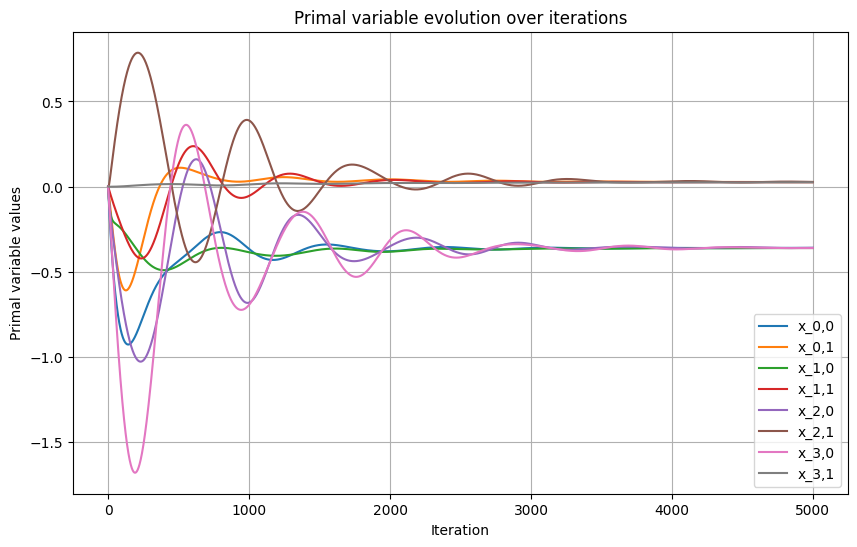

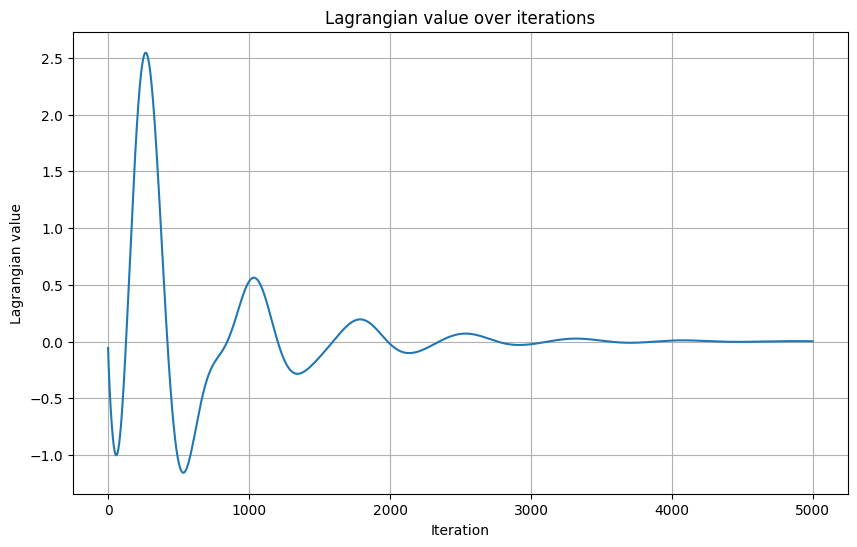

Final primal residual: 0.0024695812371969468
Final primal solution x: [[-0.36096222  0.02633345]
 [-0.36153132  0.02537349]
 [-0.35979666  0.02683059]
 [-0.3615436   0.02448446]]
Final dual solution v: [-0.65876808  0.02314637  1.01723631 -0.40933127 -0.98077005 -1.57810376
  0.62230182  1.96428866]


In [11]:
import numpy as np
from scipy.linalg import inv
import matplotlib.pyplot as plt

# Define the rotation matrix L(theta)
def L(theta):
    L_base = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return L_base

# Define the diagonal matrix D(gamma)
def D(gamma):
    D_base = np.diag([gamma, 1/gamma])
    return D_base

# Define the cost function F(x) without the penalty term
def F_x(x):
    x = np.array(x).reshape(n, p)  # Reshape x to be n x p
    total_cost = 0
    for i in range(n):
        x_i = x[i].reshape(-1, 1)  # Convert x_i to column vector (2x1)
        total_cost += x_i.T @ A_matrices[i] @ x_i + b_vectors[i].T @ x_i
    return total_cost.flatten()[0]

# Define the Lagrangian function L(x, v)
def lagrangian(x, v):
    x = np.array(x).flatten()
    v = np.array(v).flatten()
    return F_x(x) + v.T @ (V @ x)

# Define the primal variable update step (argmin L(x, v))
def primal_update(x, v):
    grad = gradient_lagrangian(x, v)  # Compute gradient of the Lagrangian with respect to x
    return x - fixed_step_size * grad  # Update x using gradient descent

# Define the gradient of the Lagrangian with respect to x
def gradient_lagrangian(x, v):
    x = x.reshape(n, p)  # Reshape x to be n x p
    grad = np.zeros_like(x)

    # Gradient of F(x)
    for i in range(n):
        x_i = x[i].reshape(-1, 1)  # Convert x_i to column vector (2x1)
        grad_i = 2 * (A_matrices[i] @ x_i + b_vectors[i])
        grad[i] = grad_i.flatten()

    # Add the term from the dual variables (v term)
    # V is (4x4 ⊗ 2x2) so V.T @ v will give a (8, 1) result
    # Reshape the result of V.T @ v to match (n, p) = (4, 2)
    dual_term = (V.T @ v.reshape(-1, 1)).reshape(n, p)
    
    # Add the dual term to the gradient
    grad += dual_term
    
    return grad.flatten()

# Define the dual variable update step
def dual_update(v, x):
    v = np.array(v).flatten()
    return v + fixed_step_size * (V @ x.flatten())

# Adjacency list for the graph (undirected)
adj_list = {
    0: [1, 2],
    1: [0, 3],
    2: [0, 3],
    3: [1, 2]
}

# Number of nodes and dimension of x_i
n = 4
p = 2

# Initialize the weight matrix W
W = np.zeros((n, n))
for i in range(n):
    neighbors = adj_list[i]
    weight = 1 / len(neighbors)
    for j in neighbors:
        W[i, j] = weight

# Define edges for incidence matrix
edges = [(0, 1), (1, 3), (3, 2), (2, 0)]
m = len(edges)

# Compute the incidence matrix B
B = np.zeros((m, n))
for idx, (i, j) in enumerate(edges):
    weight = np.sqrt(W[i, j])
    B[idx, i] = weight
    B[idx, j] = -weight

# Define V as B ⊗ I, where I is a 2x2 identity matrix
I_2 = np.eye(p)
V = np.kron(B, I_2)

# Define the parameters for each node
i_values = np.arange(1, 5)
theta_values = i_values * (np.pi / 4)
gamma_values = 1/(2**i_values)

# Calculate A_i and b_i for each node
A_matrices = [L(theta_values[i]).dot(D(gamma_values[i])).dot(inv(L(theta_values[i]))) for i in range(4)]
b_vectors = [L(np.pi/8)**i @ np.array([[1], [0]]) for i in i_values]

# Distributed dual ascent parameters
max_iterations = 5000
tolerance = 1e-6
fixed_step_size = 0.01

# Initialize the primal (x) and dual (v) variables
x_nodes = np.zeros((n, p))
v_nodes = np.zeros((m, p))  # One dual variable for each edge

# Store the evolution of primal variables for plotting
primal_solutions = []
lagrangian_values = []

# Distributed dual ascent loop
for k in range(max_iterations):
    # Store the current primal solution
    primal_solutions.append(x_nodes.copy())

    # Update primal variables
    x_flat = primal_update(x_nodes.flatten(), v_nodes.flatten())
    x_nodes = x_flat.reshape(n, p)
    
    # Update dual variables
    v_nodes = dual_update(v_nodes, x_nodes)

    # Store the Lagrangian value
    lagrangian_values.append(lagrangian(x_nodes, v_nodes))

    # Check for convergence (based on primal and dual residuals)
    primal_residual = np.linalg.norm(V @ x_nodes.flatten())
    if primal_residual < tolerance:
        break

# Convert results for easier plotting
primal_solutions = np.array(primal_solutions)
lagrangian_values = np.array(lagrangian_values)

# Plot the primal variable evolution
plt.figure(figsize=(10, 6))
for i in range(n):
    for j in range(p):
        plt.plot(primal_solutions[:, i, j], label=f'x_{i},{j}')
plt.xlabel('Iteration')
plt.ylabel('Primal variable values')
plt.title('Primal variable evolution over iterations')
plt.legend()
plt.grid(True)
plt.show()

# Plot the Lagrangian values
plt.figure(figsize=(10, 6))
plt.plot(lagrangian_values, label='Lagrangian value')
plt.xlabel('Iteration')
plt.ylabel('Lagrangian value')
plt.title('Lagrangian value over iterations')
plt.grid(True)
plt.show()

# Final results
print(f"Final primal residual: {primal_residual}")
print(f"Final primal solution x: {x_nodes}")
print(f"Final dual solution v: {v_nodes}")

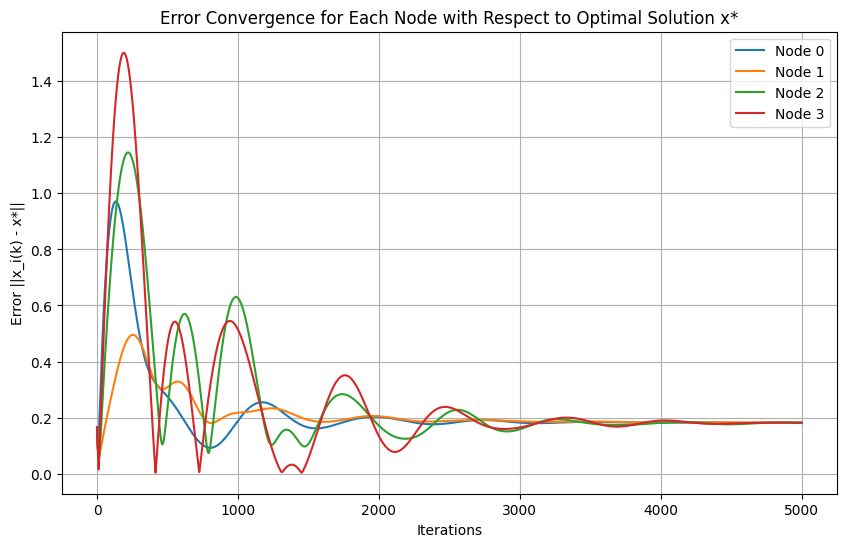

In [14]:
# Given optimal solution x*
x_star = np.array([-0.17997322, 0.0125382])

# Initialize error list to store error per iteration for each node
errors_per_iteration = []
# Initialize the primal (x) and dual (v) variables
x_nodes = np.zeros((n, p))
v_nodes = np.zeros((m, p))  # One dual variable for each edge

# Store the evolution of primal variables for plotting
primal_solutions = []
lagrangian_values = []

# Run the dual ascent algorithm for max_iterations iterations
for k in range(max_iterations):
    # Store the current primal solution
    primal_solutions.append(x_nodes.copy())

    # Update primal variables
    x_flat = primal_update(x_nodes.flatten(), v_nodes.flatten())
    x_nodes = x_flat.reshape(n, p)
    
    # Update dual variables
    v_nodes = dual_update(v_nodes, x_nodes)

    # Compute the error for each node with respect to the optimal solution
    # We compute the norm of the difference between the current x_i and the optimal x_star
    error = np.linalg.norm(x_nodes - x_star, axis=1)  # norm for each node i
    errors_per_iteration.append(error)

    # Store the Lagrangian value
    lagrangian_values.append(lagrangian(x_nodes, v_nodes))

    # Check for convergence (based on primal and dual residuals)
    primal_residual = np.linalg.norm(V @ x_nodes.flatten())
    if primal_residual < tolerance:
        break

# Convert the list of errors to a numpy array for easier plotting
errors_per_iteration = np.array(errors_per_iteration)  # Shape: (iterations, n)

# Plotting the error convergence for each node
plt.figure(figsize=(10, 6))
for i in range(n):
    plt.plot(np.arange(len(errors_per_iteration)), errors_per_iteration[:, i], label=f'Node {i}')
plt.xlabel('Iterations')
plt.ylabel('Error ||x_i(k) - x*||')
plt.title('Error Convergence for Each Node with Respect to Optimal Solution x*')
plt.legend()
plt.grid(True)
plt.show()
